In [27]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import confusion_matrix, plot_precision_recall_curve, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve

from sklearn.svm import SVC

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split, GridSearchCV

from catboost import CatBoostClassifier

import itertools
import shap

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("breast-cancer.data", header = None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


7. Attribute Information:
   1. Class: no-recurrence-events, recurrence-events
   2. age: 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99.
   3. menopause: lt40, ge40, premeno.
   4. tumor-size: 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44,
                  45-49, 50-54, 55-59.
   5. inv-nodes: 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26,
                 27-29, 30-32, 33-35, 36-39.
   6. node-caps: yes, no.
   7. deg-malig: 1, 2, 3.
   8. breast: left, right.
   9. breast-quad: left-up, left-low, right-up,	right-low, central.
  10. irradiat:	yes, no.

In [4]:
df.columns = ['Class', 'age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        286 non-null    object
 1   age          286 non-null    object
 2   menopause    286 non-null    object
 3   tumor-size   286 non-null    object
 4   inv-nodes    286 non-null    object
 5   node-caps    286 non-null    object
 6   deg-malig    286 non-null    int64 
 7   breast       286 non-null    object
 8   breast-quad  286 non-null    object
 9   irradiat     286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [6]:
df['irradiat'] = df['irradiat'].apply(lambda x: 1 if x=='yes' else 0)

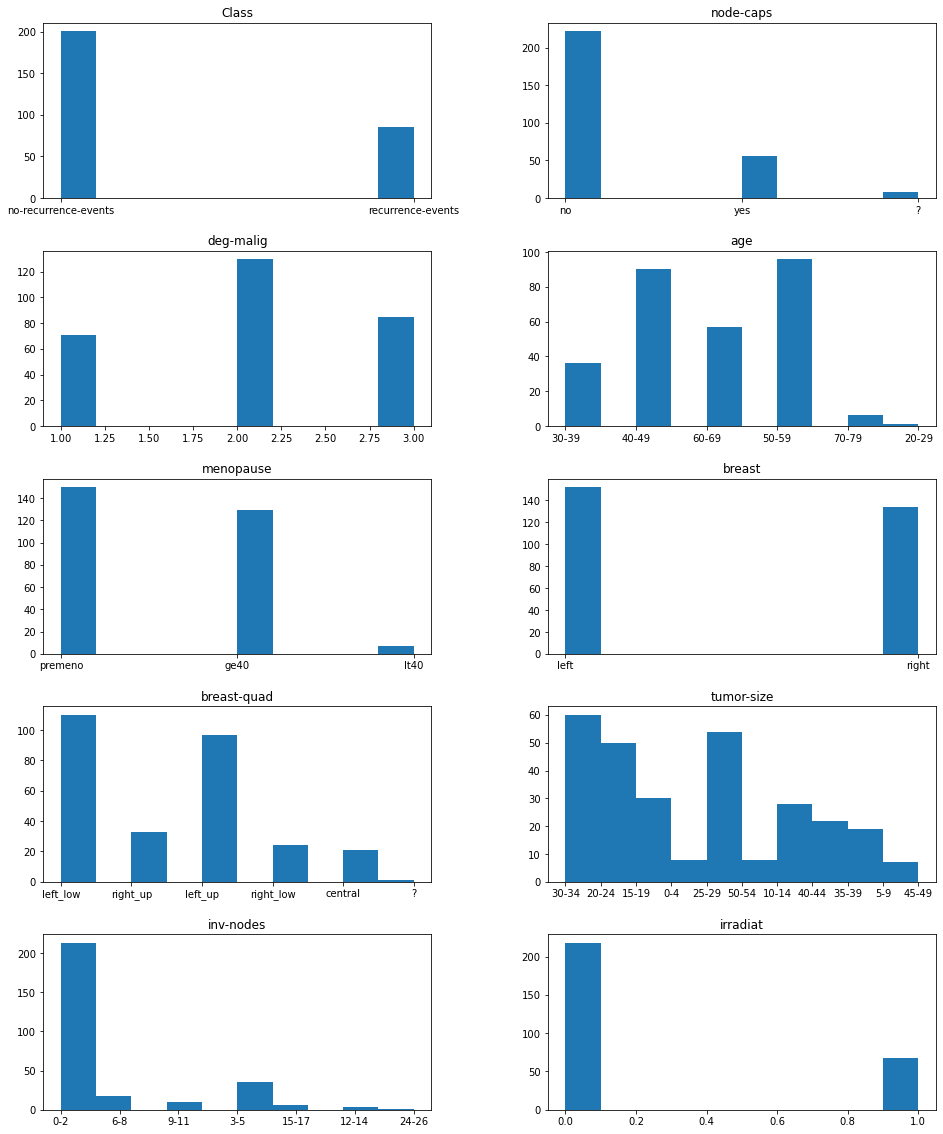

In [7]:
n_cols = 2
n_rows = 5
fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
fig.set_size_inches(16, 20)
fig.subplots_adjust(wspace=0.3, hspace=0.3)
for n, column in enumerate(df.columns):
    i = n%n_rows
    j = n%n_cols
    ax[i][j].hist(df[column])
    ax[i][j].set_title(column)


попробуем преобразовать в численные признаки некоторые колонки

In [8]:
adj_columns = []
categorical_columns = ['Class', 'menopause', 'node-caps', 'breast', 'breast-quad', 'inv-nodes', 'tumor-size', 'age']
num_columns = ['deg-malig']

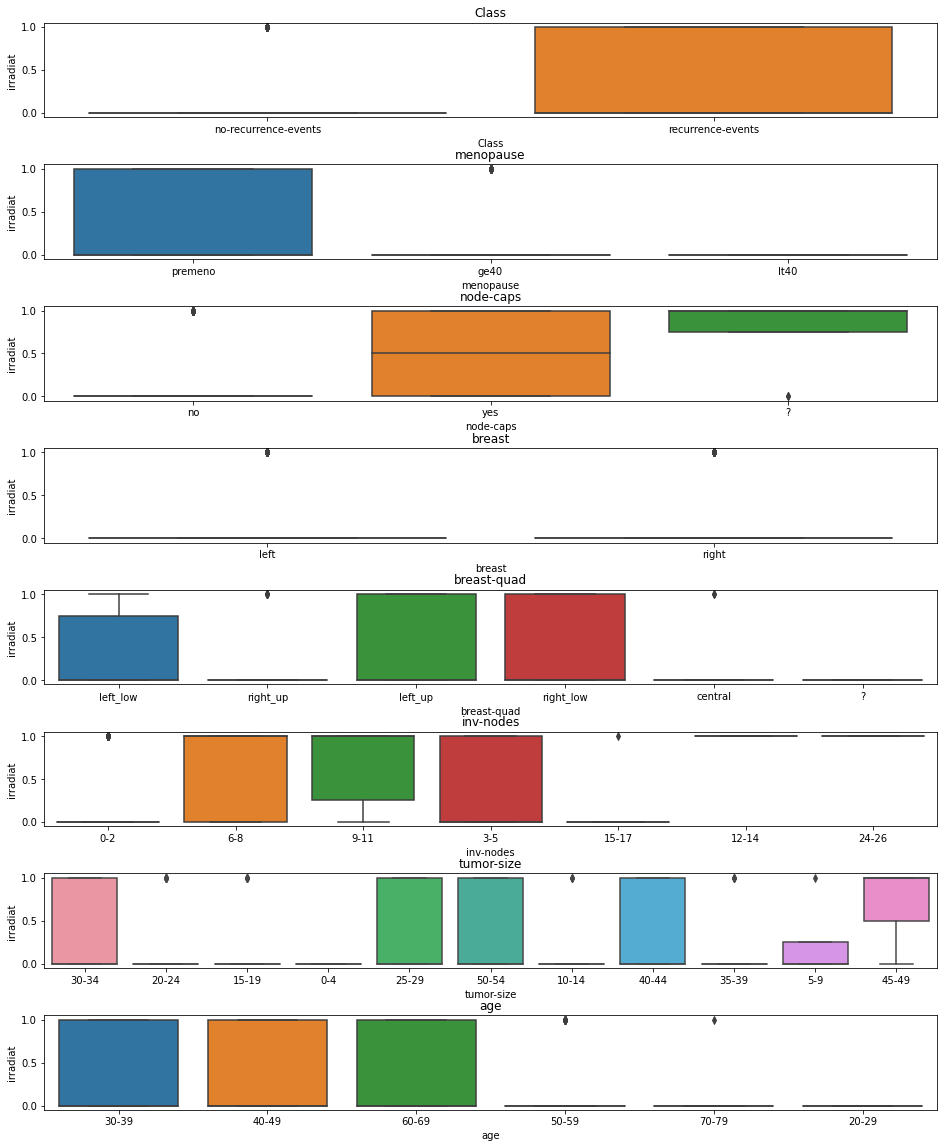

In [10]:
fig, x = plt.subplots(8)
fig.set_size_inches(16, 20)
fig.subplots_adjust(wspace=0.3, hspace=0.5)
for i, column in enumerate(categorical_columns):
    sns.boxplot(y = df['irradiat'], x = column, data=df, ax = x[i])
    x[i].set_title(column)

In [11]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [12]:
#не прригодилось
class get_border(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self
        
    def transform(self, X,  y=None):
        X = X.str.split("-")
        X = X.apply(lambda x: x[-1])
        X = X.astype('int')
        X = X.to_frame()
        return X

In [13]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for num_col in num_columns:
    num_transformer = Pipeline([
                ('selector', NumberSelector(key=num_col))
            ])
    final_transformers.append((num_col, num_transformer))
    
for adj_col in adj_columns:
    cont_transformer = Pipeline([
                ('selector', FeatureSelector(column=adj_col)),
                ('get_border', get_border(key=adj_col)),
                ('scaller', StandardScaler())
            ])
    final_transformers.append((adj_col, cont_transformer))

In [17]:
feats = FeatureUnion(final_transformers)

In [18]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
x_train.head()

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad
165,no-recurrence-events,40-49,premeno,20-24,3-5,no,2,right,left_up
39,no-recurrence-events,40-49,premeno,30-34,0-2,no,1,left,left_low
217,recurrence-events,40-49,premeno,15-19,0-2,no,2,left,left_up
177,no-recurrence-events,60-69,ge40,10-14,0-2,no,2,left,left_low
214,recurrence-events,60-69,ge40,40-44,0-2,no,2,right,left_low


In [20]:
pipeline = Pipeline([
    ('features', feats),
    ('classifier', CatBoostClassifier(silent=True, eval_metric = 'F1'))
])

In [21]:
grid = {'learning_rate': [0.03, 0.06, 0.09],
        'depth': [4, 5, 6],
        'l2_leaf_reg': [7, 8, 9]}
model = pipeline.named_steps.classifier
grid_search_result = model.grid_search(grid, 
                                       X=pipeline.named_steps.features.fit_transform(x_train), 
                                       y=y_train, plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.4705882353
bestIteration = 0


bestTest = 0.5714285714
bestIteration = 8


bestTest = 0.5333333333
bestIteration = 6


bestTest = 0.5
bestIteration = 819


bestTest = 0.5714285714
bestIteration = 8


bestTest = 0.5333333333
bestIteration = 6


bestTest = 0.5
bestIteration = 798


bestTest = 0.5714285714
bestIteration = 8


bestTest = 0.5333333333
bestIteration = 6


bestTest = 0.5333333333
bestIteration = 202


bestTest = 0.5
bestIteration = 1


bestTest = 0.5
bestIteration = 1


bestTest = 0.5
bestIteration = 1


bestTest = 0.5
bestIteration = 1


bestTest = 0.5
bestIteration = 1


bestTest = 0.5
bestIteration = 1


bestTest = 0.5
bestIteration = 1


bestTest = 0.5
bestIteration = 1


bestTest = 0.5333333333
bestIteration = 162


bestTest = 0.5
bestIteration = 163


bestTest = 0.5555555556
bestIteration = 457


bestTest = 0.5
bestIteration = 222


bestTest = 0.5
bestIteration = 129


bestTest = 0.5
bestIteration = 33


bestTest = 0.5
bestIteration = 258


bestTest = 0.5


In [23]:
grid_search_result['params']

{'depth': 4, 'l2_leaf_reg': 7, 'learning_rate': 0.06}

In [24]:
y_hat = pipeline.predict(x_test)

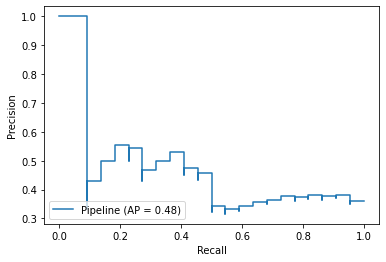

In [28]:
plot_precision_recall_curve(pipeline, x_test, y_test)

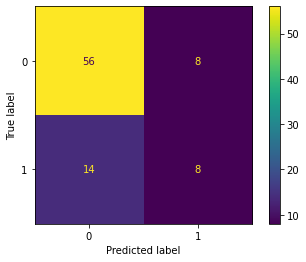

In [34]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_hat)).plot()

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(pipeline.named_steps.features.transform(x_train))

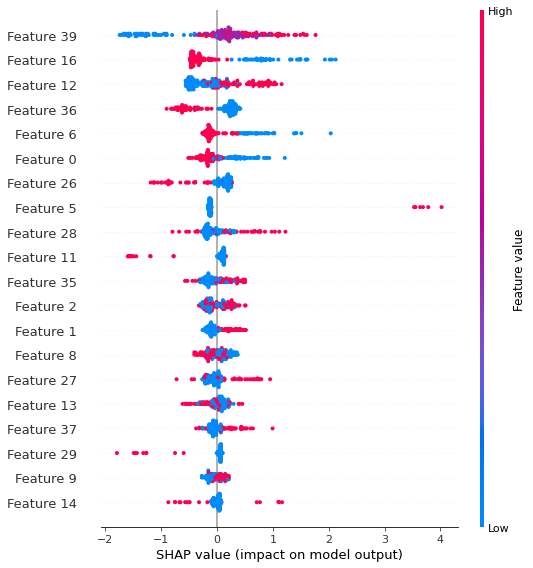

In [36]:
shap.summary_plot(shap_values, pipeline.named_steps.features.transform(x_train))

вопрос, после преобразования данных в пайплайне теряются заголовки, фичи становятся просто 1, 2, 3 и т.д. Как интерпретировать тогда фичи?